In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math
from os import path

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.aer.noise import NoiseModel

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def bf_to_dec(s):
    n = 0.
    for i in range(len(s)):
        n += float(s[i])*2**(-(i+1))
    return n

def p(theta, phase):
    return np.sin(2**t*np.pi*(theta-phase))**2/(2**(2*t)*np.sin(np.pi*(theta-phase))**2)

def phase_kickback(circ, t, phase):
    '''
    First part of PEA, consisting on applying repeated
    controlled U gates in order to kickback the phase
    to the first register
    '''
    for i in range(t):
        circ.h(i)
        for j in range(2**(t-1-i)):
            circ.cu1(2*np.pi*phase, i, -1)
    circ.barrier()
    
def inv_qft(circ, t):
    '''
    Second part of PEA, applying the inverse QFT
    to the first register of t qubits
    '''
    for i in range(math.floor(int(t/2))):
        circ.swap(i, t-1-i)
    for i in range(t):
        for j in range(i):
            circ.cu1(-2*np.pi/2**(i+1-j), t-j-1, t-1-i)
        circ.h(t-i-1)
    circ.barrier()

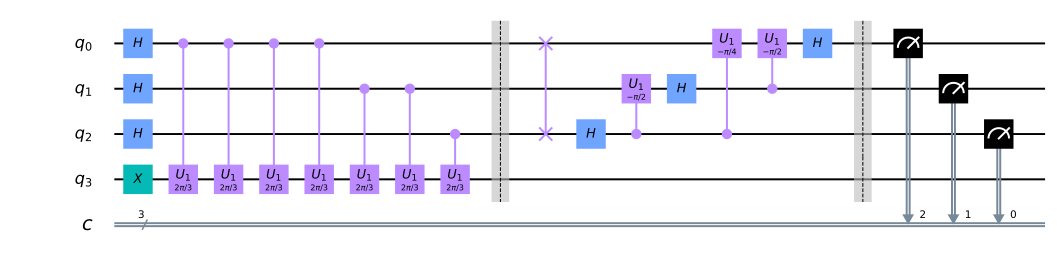

In [3]:
# PEA implementation

phase = 1./3

t = 3 # number of qubits for storing the phase estimation

circ = QuantumCircuit(t+1, t)
circ.x(-1) # Prepare the eigenstate
phase_kickback(circ, t, phase)
inv_qft(circ, t)

# measure the first register
# reverse measuring order to get correct formatting
for i in range(t):
    circ.measure(i, t-1-i)

circ.draw(output='mpl')

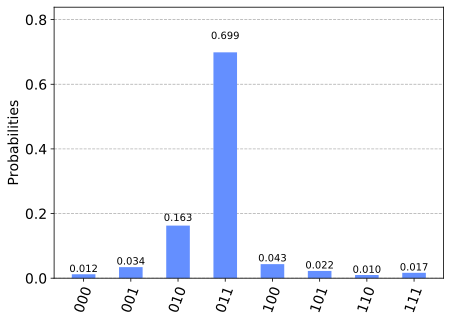

In [4]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(circ, backend=backend, shots=shots).result()
answer = results.get_counts()

%config InlineBackend.figure_format = 'svg'
plot_histogram(answer)

Text(0, 0.5, 'Probabilities')

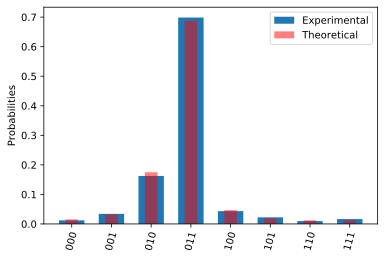

In [5]:
answer_dec = {bf_to_dec(key):value/shots for key, value in zip(answer.keys(), answer.values())}

t_answer_dec = {key:p(key, phase) for key in answer_dec.keys()}


plt.bar(answer_dec.keys(), answer_dec.values(), width=0.08, label='Experimental')
plt.bar(t_answer_dec.keys(), t_answer_dec.values(), alpha=0.5, width=0.04, color='red', label='Theoretical')
plt.xticks(list(answer_dec.keys()), list(answer.keys()), rotation=75)
plt.legend()
plt.ylabel('Probabilities')

In [6]:
# AVERAGE RULE: Take most probable value as an estimation
print('MAJORITY RULE')
print()
est_phase = max(answer_dec, key=answer_dec.get)
print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+1) = {}'.format(2**(-(t+1))))

MAJORITY RULE

Estimated phase: 0.375
Phase: 0.333
Accuracy: 0.042
2^-(t+1) = 0.0625


In [7]:
# AVERAGE RULE: Use circular statistics to get an estimation


def mu(phase):
    A = 2**t -1
    return np.arctan((A*np.sin(2*np.pi*phase)-np.sin(A*2*np.pi*phase))/(A*np.cos(2*np.pi*phase) + np.cos(A*2*np.pi*phase)))/(2*np.pi)

def mu2(phase):
    A = 2**t -1
    return np.arctan2((A*np.sin(2*np.pi*phase)-np.sin(A*2*np.pi*phase)), (A*np.cos(2*np.pi*phase)+ np.cos(A*2*np.pi*phase)))/(2*np.pi)

def rho(phase):
    A = 2**t - 1
    return np.sqrt(4**(-t)*(4**t - 2**(t+1)+2+2*A*np.cos(2**(t+1)*np.pi*phase)))

# First trigonometric moment about the mean direction

theta_1 = np.sum([value*np.exp(2*np.pi*1j*key) for key, value in zip(answer_dec.keys(), answer_dec.values())])


est_phase = np.angle(theta_1)/(2*np.pi)

print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+2) = {}'.format(2**(-(t+2))))

mrl = np.absolute(theta_1)
sigma = np.sqrt(-2*np.log(mrl))/(2*np.pi)
print(sigma)

Estimated phase: 0.3559507927224108
Phase: 0.333
Accuracy: 0.023
2^-(t+2) = 0.03125
0.10083750428870944


# Simulation with noise

In [8]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to n qubits
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_ourense')
#backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= t+1 and not x.configuration().simulator and x.status().operational==True))
print("backend: ", backend)

# Run with 2048 shots
shots = 2048

backend:  ibmq_ourense


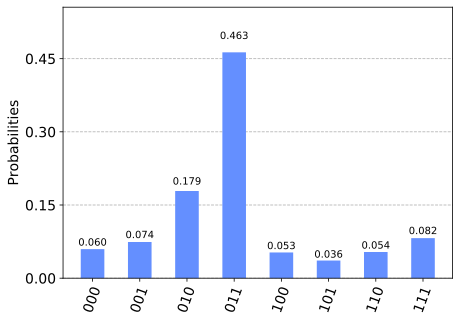

In [9]:
# Build noise model from backend properties
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
result = execute(circ, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
answer = result.get_counts(0)
plot_histogram(answer)

Text(0, 0.5, 'Probabilities')

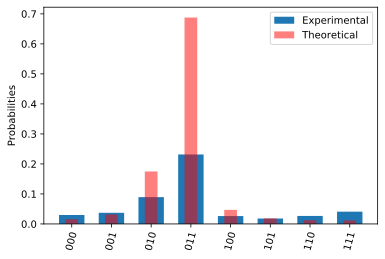

In [10]:
answer_dec = {bf_to_dec(key):value/shots for key, value in zip(answer.keys(), answer.values())}

t_answer_dec = {key:p(key, phase) for key in answer_dec.keys()}


plt.bar(answer_dec.keys(), answer_dec.values(), width=0.08, label='Experimental')
plt.bar(t_answer_dec.keys(), t_answer_dec.values(), alpha=0.5, width=0.04, color='red', label='Theoretical')
plt.xticks(list(answer_dec.keys()), list(answer.keys()),rotation=75)
plt.legend()
plt.ylabel('Probabilities')

In [11]:
# AVERAGE RULE: Take most probable value as an estimation
print('MAJORITY RULE')
print()
est_phase = max(answer_dec, key=answer_dec.get)
print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+1) = {}'.format(2**(-(t+1))))

MAJORITY RULE

Estimated phase: 0.375
Phase: 0.333
Accuracy: 0.042
2^-(t+1) = 0.0625


In [12]:
# First trigonometric moment about the mean direction

theta_1 = np.sum([value*np.exp(2*np.pi*1j*key) for key, value in zip(answer_dec.keys(), answer_dec.values())])


est_phase = np.abs(np.angle(theta_1)/(2*np.pi))

print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+2) = {}'.format(2**(-(t+2))))

mrl = np.absolute(theta_1)
sigma = np.sqrt(-2*np.log(mrl))/(2*np.pi)
print(sigma)

Estimated phase: 0.3311453455423195
Phase: 0.333
Accuracy: 0.002
2^-(t+2) = 0.03125
0.2683706016279416


# Running in QC

Job Status: job has successfully run


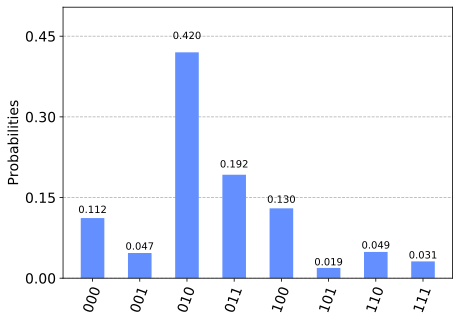

In [13]:
def save(answer, filename='test'):
    '''
    Save the results obtained from running the circuit.
    
    Input: dictionary containing the results
    '''
    np.save(filename, [list(answer.keys()), list(answer.values())])

def load(filename='test'):
    l = np.load(filename + '.npy')
    return {key:float(value) for key,value in zip(l[0], l[1])}

filename = '{}-p{}-t{}'.format(backend, round(phase, 3), t)
if path.isfile(filename + '.npy'):
    answer = load(filename)
else:
    job = execute(circ, backend=backend, shots=2048, optimization_level=3)
    job_monitor(job)
    # get the results from the computation
    results = job.result()
    answer = results.get_counts(circ)    
    save(answer, filename)

    
%config InlineBackend.figure_format = 'svg'
plot_histogram(answer)

Text(0, 0.5, 'Probabilities')

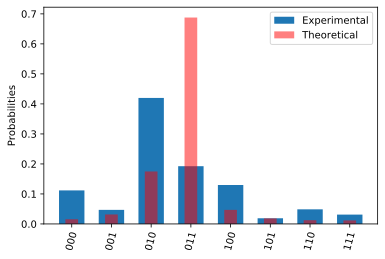

In [14]:
answer_dec = {bf_to_dec(key):value/shots for key, value in zip(answer.keys(), answer.values())}

t_answer_dec = {key:p(key, phase) for key in answer_dec.keys()}


plt.bar(answer_dec.keys(), answer_dec.values(), width=0.08, label='Experimental')
plt.bar(t_answer_dec.keys(), t_answer_dec.values(), alpha=0.5, width=0.04, color='red', label='Theoretical')
plt.xticks(list(answer_dec.keys()), list(answer.keys()),rotation=75)
plt.legend()
plt.ylabel('Probabilities')

In [15]:
# AVERAGE RULE: Take most probable value as an estimation
print('MAJORITY RULE')
print()
est_phase = max(answer_dec, key=answer_dec.get)
print('Estimated phase: {}'.format(est_phase))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+1) = {}'.format(2**(-(t+1))))

MAJORITY RULE

Estimated phase: 0.25
Phase: 0.333
Accuracy: 0.083
2^-(t+1) = 0.0625


In [16]:
# First trigonometric moment about the mean direction

theta_1 = np.sum([value*np.exp(2*np.pi*1j*key) for key, value in zip(answer_dec.keys(), answer_dec.values())])

angle = np.angle(theta_1)

if angle < 0.:
    angle += 2*np.pi

est_phase = angle/(2*np.pi)

mrl = np.absolute(theta_1)
sigma = np.sqrt(-2*np.log(mrl))/(2*np.pi)

print('Estimated phase: {} +- {}'.format(round(est_phase,3), round(sigma,3)))
print('Phase: {}'.format(round(phase, 3)))
print('Accuracy: {}'.format(round(np.abs(est_phase - phase), 3)))
print('2^-(t+2) = {}'.format(2**(-(t+2))))


print('Standard Deviation: {}'.format(round(sigma,3)))

Estimated phase: 0.285 +- 0.183
Phase: 0.333
Accuracy: 0.048
2^-(t+2) = 0.03125
Standard Deviation: 0.183
